In [171]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import random
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


In [172]:
from sklearn import svm, preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier

In [173]:
data_path = 'face_data/all_pilots/three_classes/fd_oneside_1500.csv'

data = pd.read_csv(data_path)
x = data.drop(columns=['type']) # Features
y = data['type'] # Labels

In [174]:
def get_AU_cols(nums, s):
    # return AU column name
    r = []
    for x in nums:
        start = f'AU{str(x).zfill(2)}_r'
        for stat in s:
            r += [f'{start}_{stat}']
    return r

selected_AUs = [1, 4, 7, 10, 15]
x_new = x[get_AU_cols(selected_AUs, ['max', 'mean'])]
# x_new = x

In [184]:
# for testing signal vs neutral
y.loc[(y == 'up') | (y == 'down')] = 'signal'

y


0        signal
1        signal
2        signal
3        signal
4        signal
         ...   
2150    neutral
2151    neutral
2152    neutral
2153    neutral
2154    neutral
Name: type, Length: 2155, dtype: object

In [203]:
# X_new = X[list(feature_imp.index)[0:15]]
# x_new = x
seed = 109

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3)

# normalize inputs
normalizer = preprocessing.Normalizer()
x_train_norm = normalizer.fit_transform(x_train)
x_test_norm = normalizer.transform(x_test)

# oversample inputs
over = {'random': RandomOverSampler(),
        'smote': SMOTE(),
        'adasyn': ADASYN()}

# x_train_norm, y_train = over['smote'].fit_resample(x_train_norm, y_train)


# X_train_res, y_train_res = over['smote'].fit_resample(X_train_norm, y_train)

In [204]:
clf = RandomForestClassifier(n_estimators=200, max_depth=6, max_features=x_new.shape[1], class_weight='balanced')
clf.fit(x_train_norm, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=10,
                       n_estimators=200)

In [205]:
y_pred = clf.predict(x_test_norm)

print("F1 score:", metrics.f1_score(y_test, y_pred, average=None))

F1 score: [0.82056256 0.29657795]


In [206]:
y_pred_train = clf.predict(x_train_norm)

print("F1 score:", metrics.f1_score(y_train, y_pred_train, average=None))

F1 score: [0.9014553  0.61211129]


In [207]:
# feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
# list(feature_imp.index)

In [190]:
print('Train: ', Counter(y_train))
print('Test: ', Counter(y_test))

Train:  Counter({'neutral': 1294, 'signal': 214})
Test:  Counter({'neutral': 543, 'signal': 104})


In [192]:
# Compare to Dummy
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(x_train_norm, y_train)

dummy_pred = dummy_clf.predict(x_test_norm)
print("F1 score:", metrics.f1_score(y_test, dummy_pred, average=None))

F1 score: [0.65628476 0.21772152]


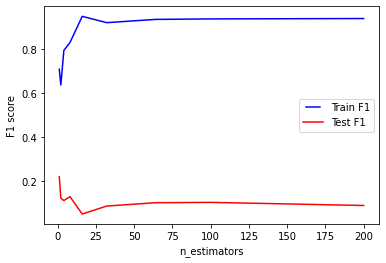

In [213]:
# parameter searching
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, max_features = x_new.shape[1], class_weight='balanced')
    rf.fit(x_train_norm, y_train)
    train_pred = rf.predict(x_train_norm)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred, pos_label='down')
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
    train_results.append(metrics.f1_score(y_train, train_pred, pos_label='signal'))
    y_pred = rf.predict(x_test_norm)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred, pos_label='down')
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(metrics.f1_score(y_test, y_pred, pos_label='signal'))
#     test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train F1")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test F1")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# parameter searching
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
# for estimator in n_estimators:
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, max_features=x_new.shape[1], class_weight='balanced', random_state=109)
    rf.fit(x_train_norm, y_train)
    train_pred = rf.predict(x_train_norm)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred, pos_label='down')
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
    train_results.append(metrics.f1_score(y_train, train_pred, pos_label='signal'))
    y_pred = rf.predict(x_test_norm)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred, pos_label='down')
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(metrics.f1_score(y_test, y_pred, pos_label='signal'))
#     test_results.append(roc_auc)
line1, = plt.plot(max_depths, train_results, 'b', label="Train F1")
line2, = plt.plot(max_depths, test_results, 'r', label="Test F1")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depth')
plt.show()

In [14]:
r = pd.DataFrame(columns=['test', 'pred'])
r['test'], r['pred'] = y_test, y_pred
